<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/collections_demos/rms_mutation_prediction/RMS-Mutation-Prediction-Expert-Annotations_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of RMS-Mutation-Prediction-Expert-Annotations collection: Working with DICOM Structured Reports in computational pathology

This tutorial is shared as part of the tutorials prepared by the Imaging Data Commons team and available at https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks.

---

`RMS-Mutation-Prediction-Expert-Annotations` is collection available in the [NCI Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov) that contains expert annotations of tissue types for 95 patients of the digital pathology slide images in the `RMS-Mutation-Prediction` collection released earlier. You can learn more about this collection in the following dataset record:

> Bridge, C., Brown, G. T., Jung, H., Lisle, C., Clunie, D., Milewski, D., Liu, Y., Collins, J., Linardic, C. M., Hawkins, D. S., Venkatramani, R., Fedorov, A., & Khan, J. (2024). Expert annotations of the tissue types for the `RMS-Mutation-Prediction` microscopy images [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10462858

You can access this annotations collection in the IDC Portal using [this link](https://portal.imaging.datacommons.cancer.gov/explore/filters/?analysis_results_id=RMS-Mutation-Prediction-Expert-Annotations), or you can explore its content using this [custom Google Looker dashboard](https://tinyurl.com/idc-rms-annotations).

As is the case with all of the content of IDC, both the images and annotations are publicly available and are free to download!

In this notebook we give you an overview of this collection, and demonstrate how to navigate its content programmatically.

---

There are different ways to store annotations in DICOM, depending on the type of the annotation, and the specific DICOM object used. In this notebook we will discuss how to use planar closed contour annotations stored in [DICOM Structured Report](https://dicom.nema.org/dicom/2013/output/chtml/part20/sect_A.3.html) (SR) documents, which is the representation of annotations adopted in the `RMS-Mutation-Prediction-Expert-Annotations` collection. Using the example of expert-generated region annotations in rhabdomyosarcoma tumour slides, which have [recently been ingested into the NCI Imaging Data Commons](https://datascience.cancer.gov/news-events/news/rhabdomyosarcoma-images-now-available-through-nci-imaging-data-commons) (IDC), the organization of annotations stored in such SR objects is explained, and examples of how those annotations can be used and combined with the respective DICOM whole-slide images (WSIs) are provided.

If you have any questions about this tutorial, please ask them on IDC forum: https://discourse.canceridc.dev

---

Initial version: May 2024

Updated: June 2024

<img src="https://raw.githubusercontent.com/ImagingDataCommons/IDC-Tutorials/master/notebooks/collections_demos/rms_mutation_prediction/assets/rms_annotation_slim_example.png" alt="Example visualization of annotations" width="1000"/>

## Prerequisites
**Installations**
* **Install highdicom:** Most code in this notebook relies on the Python library [highdicom](https://highdicom.readthedocs.io/en/latest/introduction.html) which was specifically designed to work with DICOM objects holding image-derived information, e.g. annotations and measurements. Further and more detailed information on highdicom's functionality can be found in its [user guide](https://highdicom.readthedocs.io/en/latest/usage.html).
* **Install wsidicom:** The [wsidicom](https://pypi.org/project/wsidicom/) Python package provides functionality to open and extract image or metadata from WSIs.
* **Install rasterio:** [rasterio](https://rasterio.readthedocs.io/en/stable/installation.html) is a Python package to facilitate working with many types of rasterized data.
* **Install idc-index:** The Python package [idc-index](https://pypi.org/project/idc-index/) facilitates queries of the basic metadata and download of DICOM files hosted by the IDC.
* **Install DCMTK:** [DCMTK (DICOM Toolkit)](https://dcmtk.org/en/) is an ope-source library that provides some convenient command-line tools for examining DICOM files.

In [ ]:
%%capture
!pip install highdicom
!pip install wsidicom
!pip install rasterio
!pip install idc-index --upgrade

In [ ]:
%%capture
!sudo apt-get install dcmtk

## Imports

In [ ]:
import os
from glob import glob
import json
import random
import pydicom
import shapely
import duckdb
import highdicom as hd
import numpy as np
np.set_printoptions(threshold = 50)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from idc_index import IDCClient
from wsidicom import WsiDicom
from wsidicom.instance.dataset import WsiDataset
from collections import defaultdict
from rasterio.features import is_valid_geom, rasterize
from shapely.geometry.polygon import Polygon
from typing import Dict, List, Tuple, Union

## Accessing DICOM SRs from the IDC
For the first step - to access and download the SR documents from the RMS collection - we use the Python package idc-index that we installed previously.

In [ ]:
idc_client = IDCClient() # set-up idc_client
index_df = idc_client.index # get general metadata table

In [ ]:
query_sr = '''
SELECT
    SeriesInstanceUID,
    StudyInstanceUID,
    PatientID
FROM
    index_df
WHERE
    collection_id = 'rms_mutation_prediction' AND Modality = 'SR'
'''
rms_srs = idc_client.sql_query(query_sr)

In [ ]:
dcm_sr_dir = '/content/dicom_sr_annotations'
os.makedirs(dcm_sr_dir, exist_ok=True)

idc_client.download_from_selection(downloadDir=dcm_sr_dir,
                                   seriesInstanceUID=rms_srs['SeriesInstanceUID'].tolist(), dirTemplate=None)
dcm_sr_paths = [os.path.join(dcm_sr_dir, filepath) for filepath in os.listdir(dcm_sr_dir)] # collect all SR document paths

All annotations on its respective slide can also be viewed and explored in detail using the Slim viewer. Click the link generated by the code cell below to see one example. In the Slim viewer's interface switch the slider(s) at the right sidebar to make annotations visible.  

In [ ]:
viewer_url = idc_client.get_viewer_URL(studyInstanceUID=rms_srs['StudyInstanceUID'].iloc[0], viewer_selector='slim')
from IPython.display import IFrame
IFrame(viewer_url, width=1600, height=900)

## Quick glance on the RMS collection
The RMS annotation collection contains expert-annotated regions of interest (ROI) for ~90 H&E stained slides of the RMS image collection. The ROIs delineate tissue regions with alveolar or embryonal rhabdomyosarcoma (ARMS or ERMA) as well as necrotic or connective tissue.

Run the following code cell (please be patient for a minute or two) to get a quick overview of what the RMS annotation collection has to offer.
Running the hidden code cell below will output a dataframe that shows how many annotations of a certain tissue type (column) are available per slide (row). For each slide you also find a link to the Slim viewer to investigate the slide and its annotations visually.

In [ ]:
#@title Click below to run the code cell

def quick_glance_on_rms_collection(dcm_sr_dir: str, idc_client) -> None:
    measurements_and_rois = defaultdict(lambda: defaultdict(list))
    for dcm_sr_path in dcm_sr_paths:
        planar_measurement_groups = hd.sr.srread(dcm_sr_path).content.get_planar_roi_measurement_groups()
        for m_group in planar_measurement_groups:
            study_instance_uid = hd.sr.srread(dcm_sr_path).StudyInstanceUID
            slim_viewer_url = idc_client.get_viewer_URL(studyInstanceUID=study_instance_uid, viewer_selector='slim')
            measurements_and_rois[(dcm_sr_path, slim_viewer_url)][m_group.finding_type.meaning].append(m_group.roi)
    df_measurements_and_rois = pd.DataFrame.from_dict(measurements_and_rois, orient='index')

    counts = defaultdict()
    for finding in df_measurements_and_rois.columns:
        counts[finding] = df_measurements_and_rois[finding].apply(lambda e: len(e) if isinstance(e, list) else 0)
    return pd.DataFrame(counts)

def clickable_hyperlink(val):
    return ('<a href="{}">{}</a>'.format(val, 'Slim URL'))

overview = quick_glance_on_rms_collection(dcm_sr_dir, idc_client)
overview.style.format_index(clickable_hyperlink, level=1).hide(axis='index', level=0)

,Connective tissue,Alveolar rhabdomyosarcoma,Embryonal rhabdomyosarcoma,Necrosis
Slim URL,6,1,0,0
Slim URL,10,0,8,0
Slim URL,3,2,0,0
Slim URL,1,0,2,0
Slim URL,26,29,0,0
Slim URL,2,0,1,0
Slim URL,2,0,3,3
Slim URL,3,0,7,0
Slim URL,1,0,6,0
Slim URL,1,4,0,6


If the RMS annotation collection sparked your interest and / or if you want to learn more about annotations in DICOM SR format, please continue with the following sections. They will show and explain in detail how these annotations can be read, interpreted and prepared for further use in downstream analyses.

## Reading DICOM SRs

The following paragraphs provide an overview of the concept of DICOM SRs and explain how the RMS annotation collection is encoded.

Like other DICOM files, DICOM SRs are composed of a document header plus a document body. The document body of an SR can easiest be thought of as a tree of "content items". Each "content item" is essentially a name-value pair (similar to a DICOM Data Element) and conveys one single piece of information, e.g. a clinical finding.

The DICOM standard defines multiple templates for SRs, each intended for a particular purpose. In our case, the DICOM SRs follow the [TID1500 "Measurement Report"](https://dicom.nema.org/medical/dicom/current/output/chtml/part16/chapter_A.html#sect_TID_1500) template, which is designed to comprise groups of measurements or qualitative evaluations ("Measurement Group"). The measurements or evaluations can either refer to an entire image/image frame or to a defined 2D or 3D ROI within an image depending on the type of the "Measurement Group".

A "Measurement Group" can be one of the following three types, however, the types can be mixed and matched within one SR:
1. [Measurement and Qualitative Evaluation Group](https://highdicom.readthedocs.io/en/latest/tid1500.html#measurements-and-qualitative-evaluations-group-tid1501): contains measurements or evaluations that refer to one or more entire images or image frames.
2. [Planar ROI Measurements and Qualitative Evaluations](https://highdicom.readthedocs.io/en/latest/tid1500.html#planar-roi-image-measurements-group-tid1410): contains measurements or evaluations and the 2D regions of interest those refer to.
3. [Volumetric ROI Measurements and Qualitative Evaluations](https://highdicom.readthedocs.io/en/latest/tid1500.html#volumetric-roi-image-measurements-group-tid1411): contains measurements or evaluations and the 3D regions those refer to.

ROIs can be specified indirectly as a reference to a specific region which is stored in a separate DICOM file or they can be specified explicitly as contour points (e.g. a Circle or a Polygon) along with the measurements and/or findings. Contour points may either be 2D points in the image coordinate system or 3D points in the frame-of-reference coordinate system ([SCOORD vs. SCOORD3D](https://highdicom.readthedocs.io/en/latest/generalsr.html#graphic-data-content-items-scoord-and-scoord3d)).  

The RMS annotations are stored in measurement groups of type "Planar ROI Measurements and Qualitative Evaluations", where each finding (e.g. necrotic tissue) is accompanied by the annotated region encoded as a planar SCOORD3D contour.
The following code uses the python library [highdicom](https://github.com/ImagingDataCommons/highdicom) to extract those findings and contours from a single DICOM SR of the RMS collection.

Explanations and guidance through implementation details in highdicom can be found [here](https://highdicom.readthedocs.io/en/latest/sr.html).
A more detailed description of the theory of SR documents can be found in [this book](https://www.dclunie.com/pixelmed/DICOMSR.book.pdf), the [DICOM standard](https://dicom.nema.org/medical/dicom/current/output/chtml/part21/sect_a.3.html) or [this white paper](http://dx.doi.org/10.13140/RG.2.2.34520.62725).



In [ ]:
def extract_planar_measurements_groups(sr_path: str) -> List[hd.sr.PlanarROIMeasurementsAndQualitativeEvaluations]:
    """ Function using highdicom to access measurement groups of type 'PlanarROIMeasurementsAndQualitativeEvaluations'. """
    sr = hd.sr.srread(sr_path)
    measurements = sr.content
    measurement_groups = measurements.get_planar_roi_measurement_groups()
    return measurement_groups

The following code snippet uses the previously defined function to access planar measurement groups in a randomly selected RMS SR document and displays one of those measurement groups:

In [ ]:
sr_path_example1 = random.choice(dcm_sr_paths)
planar_measurement_groups_example1 = extract_planar_measurements_groups(sr_path_example1)
print(f'This SR document contains {len(planar_measurement_groups_example1)} "Planar ROI Measurements and Qualitative Evaluations".')
print(f'An example measurement group of type "Planar ROI Measurements and Qualitative Evaluations": \n{planar_measurement_groups_example1[0]}')

This SR document contains 14 "Planar ROI Measurements and Qualitative Evaluations".
An example measurement group of type "Planar ROI Measurements and Qualitative Evaluations": 
[(0040, a010) Relationship Type                   CS: 'CONTAINS'
(0040, a040) Value Type                          CS: 'CONTAINER'
(0040, a043)  Concept Name Code Sequence  1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '125007'
   (0008, 0102) Coding Scheme Designator            SH: 'DCM'
   (0008, 0104) Code Meaning                        LO: 'Measurement Group'
   ---------
(0040, a050) Continuity Of Content               CS: 'CONTINUOUS'
(0040, a504)  Content Template Sequence  1 item(s) ---- 
   (0008, 0105) Mapping Resource                    CS: 'DCMR'
   (0040, db00) Template Identifier                 CS: '1410'
   ---------
(0040, a730)  Content Sequence  5 item(s) ---- 
   (0040, a010) Relationship Type                   CS: 'HAS OBS CONTEXT'
   (0040, a040) Value Type         

An alternative way to look at the content of a DICOM SR is by using DCMTK [`dsrdump` command line utility](https://support.dcmtk.org/docs/dsrdump.html), that will have one line for each node of the SR content tree - a lot more condensed and perhaps easier to understand representation than what you see above!

In [ ]:
!dsrdump $sr_path_example1

Comprehensive 3D SR Document

Patient             : RMS2393 (M, #RMS2393)
Study               : Histopathology (#RMS2393)
Series              : Manual region annotations (#1)
Manufacturer        : Leica Biosystems (Aperio ImageScope converted with highdicom, #b470a5258e8421128e9307575b5be382b83b1a8f)
Preliminary Flag    : FINAL
Completion Flag     : COMPLETE
Verification Flag   : UNVERIFIED
Content Date/Time   : 2024-01-18 03:15:40

<CONTAINER:(,,"Imaging Measurement Report")=CONTINUOUS>
  <has concept mod CODE:(,,"Language of Content Item and Descendants")=(en-US,RFC5646,"English (United States)")>
  <has obs context CODE:(,,"Observer Type")=(121006,DCM,"Person")>
  <has obs context PNAME:(,,"Person Observer Name")="Anonymized">
  <has obs context CODE:(,,"Subject Class")=(121027,DCM,"Specimen")>
  <has obs context UIDREF:(,,"Specimen UID")="2.25.335339101468976987066115643151117288423">
  <has obs context TEXT:(,,"Specimen Identifier")="PAKNTC-0BMX4Y_BX">
  <has obs context TEXT:(,,"

The following code shows how to access specific attributes such as the **finding type**, the **coordinates of the ROI** or the **FrameOfReferenceUID** those coordinates refer to.

In [40]:
# Extract different attributes from the measurement group
for m_group in planar_measurement_groups_example1[:3]:
  print(f'Finding type: {m_group.finding_type.meaning}')
  print(f'ROI {m_group.roi.graphic_type}')
  print(m_group.roi.value)
  print(f'ROI refers to FrameOfReferenceUID: {m_group.roi.frame_of_reference_uid}')
  print('\n')

Finding type: Embryonal rhabdomyosarcoma
ROI GraphicTypeValues3D.POLYGON
[[11.30286503 43.74634171  0.        ]
 [11.35742664 43.56674576  0.        ]
 [11.39279079 43.45231628  0.        ]
 ...
 [11.30842304 43.76276016  0.        ]
 [11.30842304 43.75720596  0.        ]
 [11.30286503 43.74634171  0.        ]]
ROI refers to FrameOfReferenceUID: 1.3.6.1.4.1.5962.99.1.3178953502.1272538196.1686806166302.7.0


Finding type: Embryonal rhabdomyosarcoma
ROI GraphicTypeValues3D.POLYGON
[[ 9.6064043  37.8423233   0.        ]
 [ 9.6607132  37.67055511  0.        ]
 [ 9.66349125 37.65438843  0.        ]
 ...
 [ 9.59806824 37.86126709  0.        ]
 [ 9.59806824 37.85848999  0.        ]
 [ 9.6064043  37.8423233   0.        ]]
ROI refers to FrameOfReferenceUID: 1.3.6.1.4.1.5962.99.1.3178953502.1272538196.1686806166302.7.0


Finding type: Embryonal rhabdomyosarcoma
ROI GraphicTypeValues3D.POLYGON
[[ 7.47041845 34.06241608  0.        ]
 [ 7.45526218 33.97905731  0.        ]
 [ 7.44642115 33.96390152

## Investigating the complete annotation collection

The following section explores the content of **all SR documents in the RMS collection** to get an overview of the available findings and annotations. Therefore, we extract and count all findings and ROIs/contours from the RMS SR documents and then visually summarize what annotations are available. The results are the same as in the section "Quick glance on the RMS collection", but the process is explained in more detail.

In [ ]:
measurements_and_rois = defaultdict(lambda: defaultdict(list))

# Collect findings and contours from all SRs in the RMS collection into a dataframe
for dcm_sr_path in dcm_sr_paths:
    planar_measurement_groups = extract_planar_measurements_groups(dcm_sr_path)
    for m_group in planar_measurement_groups:
        study_instance_uid = hd.sr.srread(dcm_sr_path).StudyInstanceUID
        slim_viewer_url = idc_client.get_viewer_URL(studyInstanceUID=study_instance_uid, viewer_selector='slim')
        measurements_and_rois[(dcm_sr_path, slim_viewer_url)][m_group.finding_type.meaning].append(m_group.roi)

df_measurements_and_rois = pd.DataFrame.from_dict(measurements_and_rois, orient='index')

Next, we will get an overview on the number of ROI annotations available for the different findings and how they are distributed among the SR documents by creating a dataframe that holds the counts of ROI annotations per finding per SR.

In [ ]:
counts = defaultdict()

# Count findings and contours from all SRs in the RMS collection
for finding in df_measurements_and_rois.columns:
    counts[finding] = df_measurements_and_rois[finding].apply(lambda e: len(e) if isinstance(e, list) else 0)

# Add Slim viewer URL and format dataframe
df_counts = pd.DataFrame(counts)

def clickable_hyperlink(val):
    return ('<a href="{}">{}</a>'.format(val, 'Slim URL'))

df_counts.style.format_index(clickable_hyperlink, level=1).hide(axis='index', level=0)

,Necrosis,Connective tissue,Embryonal rhabdomyosarcoma,Alveolar rhabdomyosarcoma
Slim URL,3,2,3,0
Slim URL,2,4,0,14
Slim URL,6,1,0,4
Slim URL,1,7,2,0
Slim URL,8,0,9,0
Slim URL,1,3,0,1
Slim URL,1,13,0,1
Slim URL,1,1,1,0
Slim URL,6,0,0,10
Slim URL,1,1,3,0


For each SR document (row, including Slim URL to view the corresponding slide), the dataframe lists the number of available ROIs per finding (column). A short look on the dataframes column headers shows that (as we learned before) there are ROIs available for four different findings:
* Embryonal rhabdomyosarcoma (abbreviated: ERMS)
* Necrosis
* Alveolar rhabdomyosarcoma (abbreviated: ARMS)
* Connective tissue  


In [ ]:
print('Total number of ROIs per finding: ')
df_counts.sum(axis=0)

Total number of ROIs per finding: 


Necrosis                       90
Connective tissue             260
Embryonal rhabdomyosarcoma    149
Alveolar rhabdomyosarcoma     181
dtype: int64

The following histogram shows for each finding the number of available ROIs per SR document:  

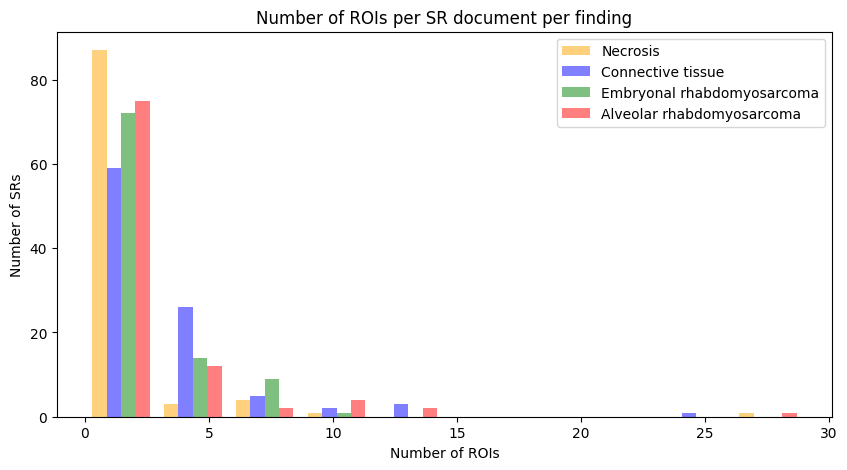

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist([val for _, val in df_counts.items()], color=['orange','b', 'g', 'r'], alpha=0.5, label = [col for col in df_counts.columns])
plt.xlabel('Number of ROIs')
plt.ylabel('Number of SRs')
plt.title('Number of ROIs per SR document per finding')
plt.legend()

Apparently, most SRs contain one or few ROI annotations per finding (however it also becomes clear that not every SR contains ROIs for all findings). Also, few SR seem to contain a lot (> 25) annotations for a finding.

Based on this knowledge, we could now, for example, decide to select only SR documents that contain at most 10 ROI annotations across all findings:

In [ ]:
selection1 = df_counts[df_counts.sum(axis=1) <= 10]
selection1.style.format_index(clickable_hyperlink, level=1).hide(axis='index', level=0)

,Necrosis,Connective tissue,Embryonal rhabdomyosarcoma,Alveolar rhabdomyosarcoma
Slim URL,3,2,3,0
Slim URL,1,7,2,0
Slim URL,1,3,0,1
Slim URL,1,1,1,0
Slim URL,1,1,3,0
Slim URL,1,0,6,0
Slim URL,2,6,0,2
Slim URL,4,2,0,3
Slim URL,2,6,0,1
Slim URL,1,2,1,0


Or we could decide to only select SRs which have ROIs for every type of finding:

In [ ]:
selection2 = df_counts[(df_counts > 0).all(axis=1)]
selection2.style.format_index(clickable_hyperlink, level=1).hide(axis='index', level=0)

,Necrosis,Connective tissue,Embryonal rhabdomyosarcoma,Alveolar rhabdomyosarcoma


We can see that there is no SR, which has ROIs for every type of finding. This is expected as in the ARMS and ERMS are usually mutually exclusive, meaning that a patient is either diagnosed with ARMS or ERMS.

Knowing this, we could however require exactly one ROI for Connective tissue, one for Necrosis and at least one ROI for RMS (either embryonal or alveolar):

In [ ]:
selection3 = df_counts[(df_counts['Connective tissue'] == 1) &
                       (df_counts['Necrosis'] == 1) &
                       ((df_counts['Embryonal rhabdomyosarcoma'] > 0) | (df_counts['Alveolar rhabdomyosarcoma'] > 0))]
selection3.style.format_index(clickable_hyperlink, level=1).hide(axis='index', level=0)

,Necrosis,Connective tissue,Embryonal rhabdomyosarcoma,Alveolar rhabdomyosarcoma
Slim URL,1,1,1,0
Slim URL,1,1,3,0
Slim URL,1,1,0,9


## Making use of annotations for further processing

Now that we know what annotations are available and how to select the ones of interest, the question arises as to how to use them for analysis, model training or other tasks in combination with the WSI to which they refer.

To demonstrate this, we select a SR which we know contains exactly one measurement group for Connective tissue, one for Necrosis and one for ERMS. To find the corresponding WSI for a SR document we look for the content of the **ReferencedSeriesSequence**.

In [ ]:
def get_referenced_series_instance_uid(sr_path: str) -> str:
    """ Function to access referenced SeriesInstanceUIDs in a SR. """
    sr = hd.sr.srread(sr_path)
    return str(sr.CurrentRequestedProcedureEvidenceSequence[0].ReferencedSeriesSequence[0].SeriesInstanceUID)

sr_path_example2 = df_counts.index[(df_counts['Connective tissue'] == 1) &
                                   (df_counts['Necrosis'] == 1) &
                                   (df_counts['Embryonal rhabdomyosarcoma'] == 1)][0][0]
''' Theoretically, SRs can refer to multiple different series, however practically this is rarely the case.'''
referenced_series_instance_uid = get_referenced_series_instance_uid(sr_path_example2)

Using the referenced SeriesInstanceUID, we can now search for the respective DICOM files in the IDC:  

In [ ]:
query_imgs_example2 = f'''
SELECT
    SeriesInstanceUID
FROM
    index_df
WHERE
    SeriesInstanceUID = '{referenced_series_instance_uid}' AND Modality = 'SM'
'''
ref_imgs_example2 = idc_client.sql_query(query_imgs_example2)

In [ ]:
referenced_slide_example2_dir = '/content/referenced_slide_example2'
os.makedirs(referenced_slide_example2_dir, exist_ok=True)
idc_client.download_from_selection(downloadDir=referenced_slide_example2_dir,
                                   seriesInstanceUID=ref_imgs_example2['SeriesInstanceUID'].tolist(), dirTemplate=None)

### Selecting the image region within the contour on a certain level

A first step in an analysis pipeline could be to extract the image region enclosed by the contour at a certain resolution (slide level). As the ROI contour is given in 3D frame-of-reference coordinates, these must first be converted into pixel indices at the respective slide level, and then the corresponding area can simply be read from the WSI.

In [ ]:
def get_slide_region_for_roi(slide: WsiDicom,
                             roi: hd.sr.content.ImageRegion3D,
                             level: int) -> 'PIL.Image.Image':
    """
    Function that takes a region of interest (ROI) in 3D frame-of-reference
    coordinates (SCOORD3D) and extracts the respective image region
    (given by a rectangular bounding box around the ROI) from the slide
    at a specified level.
    """
    pyramid_level = slide.levels.get_closest_by_level(level)
    level_metadata = pyramid_level.datasets[0]
    pixel_indices = scoord3d_to_pixel_indices(roi, level_metadata)

    # Get bounding box around ROI
    min_point = np.min(pixel_indices, axis=0)
    max_point = np.max(pixel_indices, axis=0)
    offset = (min_point[0], min_point[1])
    size = (max_point[0] - min_point[0], max_point[1] - min_point[1])

    # Extract respective slide region
    slide_region = slide.read_region(location=offset, size=size, level=pyramid_level.level)
    return slide_region

In [ ]:
def scoord3d_to_pixel_indices(roi: hd.sr.content.ImageRegion3D,
                              level_metadata: WsiDataset) -> np.ndarray:
    """
    Function that transforms 3D frame-of-reference coordinates (SCOORD3D)
    to pixel indices at a specified slide level.
    """
    # see https://highdicom.readthedocs.io/en/latest/package.html#highdicom.spatial.ReferenceToPixelTransformer
    transformer = hd.spatial.ReferenceToPixelTransformer(
            image_position=[level_metadata.TotalPixelMatrixOriginSequence[0].XOffsetInSlideCoordinateSystem,
                            level_metadata.TotalPixelMatrixOriginSequence[0].YOffsetInSlideCoordinateSystem, 0.0],
            image_orientation=level_metadata.ImageOrientationSlide,
            pixel_spacing=(level_metadata.pixel_spacing.height, level_metadata.pixel_spacing.width)
        )
    pixel_indices = transformer(roi.value)
    return pixel_indices

Here, we load (and visualize) the slide using wsidicom and define the slide level we want to work on. For defining the slide level it makes sense to check available levels first, otherwise computations might take longer if the requested level has to be downsampled from the next higher level. To keep the computing time as short as possible, we select the smallest available level, i.e. level 5.

(-0.5, 511.5, 435.5, -0.5)

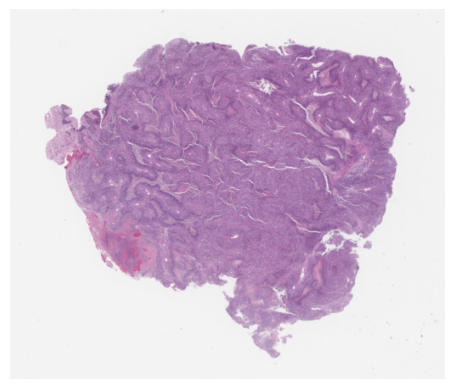

In [ ]:
slide = WsiDicom.open(referenced_slide_example2_dir)
plt.imshow(slide.read_thumbnail())
plt.axis('off')

In [ ]:
available_levels = slide.levels
print(available_levels)
my_level = 5

Pyramid of levels:
    [0]: Level: 0, size: Size(width=63743, height=54290) px, mpp: SizeMm(width=0.2526, height=0.2526) um/px Instances:       [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7bc8dacbf970>])
    [1]: Level: 2, size: Size(width=15935, height=13572) px, mpp: SizeMm(width=1.010447555695, height=1.010447555695) um/px Instances:       [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7bc8dd31fbb0>])
    [2]: Level: 4, size: Size(width=3983, height=3393) px, mpp: SizeMm(width=4.042551292995, height=4.042551292995) um/px Instances:       [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7bc8dacbd150>])
    [3]: Level: 5, size: Size(width=1991, height=1696) px, mpp: SizeMm(w

For each ROI in the SR document, we now collect the respective finding, the ROI and the slide region using the functions defined above. The slide regions are then visualized along with the findings.

In [ ]:
planar_measurement_groups_example2 = extract_planar_measurements_groups(sr_path_example2)
findings_roi_and_slide_regions = {}
for i in range(len(planar_measurement_groups_example2)):
    finding = planar_measurement_groups_example2[i].finding_type.meaning
    if finding not in findings_roi_and_slide_regions.keys():
        roi = planar_measurement_groups_example2[i].roi
        slide_region = get_slide_region_for_roi(slide, roi, level=my_level)
        findings_roi_and_slide_regions[finding] = (roi, slide_region)

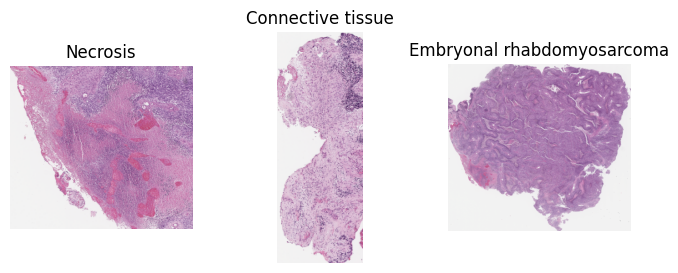

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, finding in enumerate(findings_roi_and_slide_regions.keys()):
    axes[i].imshow(findings_roi_and_slide_regions[finding][1])
    axes[i].set_title(finding)
    axes[i].axis('off')

### Converting a contour to a binary image mask on a certain level

Mostly, computational pathology algorithms do not work with contours directly, but instead work with binary or label masks to encode the ROIs.
Thus, the following code provides functionality to generate binary image masks from SCOORD3D contours at a bounding-box level. Label maps on slide-level are discussed in the section after.

In [ ]:
def roi_to_mask_in_bounding_box(slide: WsiDicom,
                    roi: hd.sr.content.ImageRegion3D,
                    mask_shape: Tuple[int],
                    level: int) -> np.ndarray:
    """
    Function that takes a region of interest (ROI) in 3D frame-of-reference
    coordinates (SCOORD3D) and generates a binary image mask for the
    slide at a specified level. The binary image mask is limited to the
    rectangular bounding box around the ROI and we use shapely Polygons
    as an intermediate step to generate the binary image masks.
    """
    pyramid_level = slide.levels.get_closest_by_level(level)
    level_metadata = pyramid_level.datasets[0]
    polygon = contour_to_polygon(roi, level_metadata)
    offset_x, offset_y = polygon.bounds[0], polygon.bounds[1]
    polygon = shapely.transform(polygon, lambda x: x - [offset_x, offset_y])
    mask = rasterize([polygon], mask_shape, dtype=np.uint8)
    return mask

In [ ]:
def contour_to_polygon(roi: 'hd.sr.content.ImageRegion3D',
                       level_metadata: WsiDataset) -> Polygon:
    """
    Function transforming a region of interest (ROI) in 3D frame-of-reference
    coordinates (SCOORD3D) to a shapely Polygon at a specific slide level.
    """
    pixel_indices = scoord3d_to_pixel_indices(roi, level_metadata)
    polygon = Polygon(pixel_indices)
    assert is_valid_geom(polygon)
    return polygon

The following code snippet iterates through our ROIs, findings and slide regions and generates plus visualizes a binary image mask for each of them.

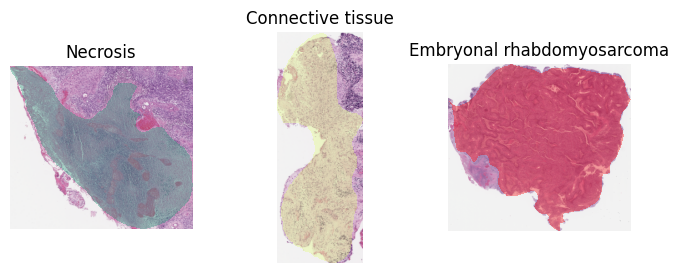

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
colormaps = ['Dark2', 'Wistia', 'hsv']

for i, finding in enumerate(findings_roi_and_slide_regions.keys()):
    roi = findings_roi_and_slide_regions[finding][0]
    slide_region = findings_roi_and_slide_regions[finding][1]
    mask_shape = tuple(reversed(slide_region.size))
    mask = roi_to_mask_in_bounding_box(slide, roi, mask_shape, level=my_level)
    axes[i].imshow(slide_region)
    axes[i].imshow(np.ma.masked_where(mask == 0, mask), cmap=colormaps[i], alpha=0.35)
    axes[i].set_title(finding)
    axes[i].axis('off')

### Converting multiple contours to a label map on a certain level

For many use cases binary or label maps for the whole slide are required instead of masks limited to the bounding-box area around the ROI.
The following code shows how to generate a label map (one label per ROI) for the whole slide.  

In [ ]:
def contour_to_label_mask_on_whole_slide(slide: WsiDicom,
                    rois: List[hd.sr.content.ImageRegion3D],
                    level: int) -> np.ndarray:
    """
    Function that takes a list of regions of interest (ROIs) in 3D frame-of-reference
    coordinates (SCOORD3D) and generates a label map for the whole slide at a specified
    level.
    """
    pyramid_level = slide.levels.get_closest_by_level(level)
    level_metadata = pyramid_level.datasets[0]
    mask_shape = (level_metadata.image_size.height, level_metadata.image_size.width)
    polygons = [contour_to_polygon(roi, level_metadata) for roi in rois]
    polygons_with_labels = [(polygon, label) for (label, polygon) in enumerate(polygons, start=1)]
    mask = rasterize(polygons_with_labels, mask_shape, dtype=np.uint8)
    return mask

In [ ]:
level_metadata = slide.levels.get_closest_by_level(my_level).datasets[0]
slide_image = slide.read_region(location=(0,0), size=(level_metadata.image_size.width, level_metadata.image_size.height),
                                level=my_level)

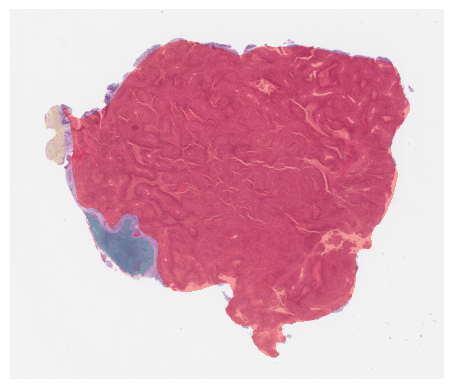

In [ ]:
plt.imshow(slide_image)
plt.axis('off')
my_cmap = colors.ListedColormap(['darkcyan', 'khaki', 'red'])
norm = colors.BoundaryNorm(boundaries=[2,3], ncolors=my_cmap.N)

rois = [planar_measurement_groups_example2[i].roi for i in range(len(planar_measurement_groups_example2))]
label_mask = contour_to_label_mask_on_whole_slide(slide, rois, level=my_level)
plt.imshow(np.ma.masked_where(label_mask == 0, label_mask), cmap=my_cmap, norm=norm, alpha=0.35)

## Exporting DICOM SRs to GeoJSON for usage in external tools

Lastly, as a lot of computational pathology tools use GeoJSON as their preferred file format for annotations, the following code shows how to easily export annotations captured in DICOM SR as GeoJSON file. This can then be imported into other tools for viewing and analysis, such as for example [QuPath](https://qupath.github.io/).

In [ ]:
def sr_to_geojson(sr_path: str, slide: WsiDicom, level: int):
    geojson = {'type':'FeatureCollection', 'features':[]}

    planar_measurement_groups = extract_planar_measurements_groups(sr_path)
    level_metadata = slide.levels.get_closest_by_level(level).datasets[0]
    for m_group in planar_measurement_groups:
        feature = {'type':'Feature',
                   'properties': {},
                   'geometry':{'type': None,
                               'coordinates':[]}}
        feature['properties'] = {'name': m_group.finding_type.meaning}
        feature['geometry']['type'] = m_group.roi.graphic_type.value.title()
        pixel_indices = scoord3d_to_pixel_indices(m_group.roi, level_metadata)
        feature['geometry']['coordinates'] = [pixel_indices.tolist()]
        geojson['features'].append(feature)

    return geojson

In [ ]:
geojson = sr_to_geojson(sr_path_example2, slide, level=my_level)
with open('example.geojson', 'w') as output_file:
    json.dump(geojson, output_file, indent=2)

This file can then be imported into other tools for viewing and analysis, such as for example [QuPath](https://qupath.github.io/).

<img src="https://raw.githubusercontent.com/ImagingDataCommons/IDC-Tutorials/master/notebooks/collections_demos/rms_mutation_prediction/assets/rms_qupath_annotations.png" alt="Example annotations visualized in QuPath" width="1000"/>

## Next steps

You can take a look at the advanced notebook demonstrating how to search DICOM SR annotations for this collection using BigQuery: https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/collections_demos/rms_mutation_prediction/RMS-Mutation-Prediction-Expert-Annotations_BigQuery.ipynb.

Share your feedback or ask questions about this notebook in IDC Forum: https://discourse.canceridc.dev.

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., Kim, E. & Kikinis, R. _National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence_. RadioGraphics (2023). [https://doi.org/10.1148/rg.230180](https://doi.org/10.1148/rg.230180)